#### Code loads data from oviraptor catalogue. The goal is to generate a bootstrap sample of transit stellar hosts that has the same distribution of masses as the RV systems. A p-chip spline is fitted to the RV distribution in order to create a probability distribution (cdf). We draw weighted samples from the transit population with weights defined by the splinecdf. For each transiting planet, we draw probabilistic values using Chen and Kipping's mass forecaster. The masses, radii, and corresponding uncertainties are used as starting points for the process. After calculating system-level parameters (Q, mu, S, C, etc.), we perform KS and AD tests on each statistic and record their p-values. Finally, for each statistic, we determine the proportion of trials the null hypothesis is rejected and the proportion that the null hypothesis is accepted.

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import LMC
import archinfo

import astropy.stats
from astropy import constants as apc

import scipy
import scipy.signal as sig
import scipy.optimize as op
from scipy import stats
from scipy.optimize import curve_fit

import dcor
import random
import collections
import importlib as imp
from KDEpy import FFTKDE

import sys
sys.path.insert(0, "./forecaster/")
import mr_forecast as mr

import time
from timeit import default_timer


# define a few constants
pi = np.pi

MJUPITER = apc.M_jup.value
MEARTH = apc.M_earth.value
MSUN = apc.M_sun.value

RJUPITER = apc.R_jup.value
REARTH = apc.R_earth.value
RSUN = apc.R_sun.value

AU = apc.au.value
BIGG = apc.G.value

In [2]:
# set manual controls and paths
NBOOT = 100

my_file = "/home/devin/Documents/Oviraptor-master/catalogues/oviraptor_crossmatch_catalog_v2.csv"

In [3]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [4]:
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [5]:
# now make the data dictionary
d = {}
d['starname'] = get_key('hostname')
d['rp'] = get_key('pl_rade')
d['rp_err1'] = get_key('pl_radeerr1')
d['rp_err2'] = get_key('pl_radeerr2')
d['mp'] = get_key('pl_bmasse')
d['mp_err1'] = get_key('pl_bmasseerr1')
d['mp_err2'] = get_key('pl_bmasseerr2')
d['rprs'] = get_key('pl_ratror')
d['rprs_err1'] = get_key('pl_ratrorerr1')
d['rprs_err2'] = get_key('pl_ratrorerr2')

d['ms'] = get_key('st_mass')
d['ms_err1'] = get_key('st_masserr1')
d['ms_err2'] = get_key('st_masserr2')
d['rs'] = get_key('st_rad')
d['rs_err1'] = get_key('st_raderr1')
d['rs_err2'] = get_key('st_raderr2')
d['p'] = get_key('pl_orbper')

d['K'] = get_key('pl_rvamp')
d['K_err1'] = get_key('pl_rvamperr1')
d['K_err2'] = get_key('pl_rvamperr2')

# disc_method can vary within a system (i.e. discovery method for each planet)
d['disc_method'] = get_key('discoverymethod')

#'sys_disc_method' should be the same for all planets in a given system
d['sys_disc_method'] = get_key('system_disc_method')

In [6]:
# transit systems will not have values for these
d['K'][d['K']==''] = [np.nan]*len(d['K'][d['K']==''])
d['K_err1'][d['K_err1']==''] = [np.nan]*len(d['K_err1'][d['K_err1']==''])
d['K_err2'][d['K_err2']==''] = [np.nan]*len(d['K_err2'][d['K_err2']==''])

# radial velocity systems will not have values for these
d['rprs'][d['rprs']==''] = [np.nan]*len(d['rprs'][d['rprs']==''])
d['rprs_err1'][d['rprs_err1']==''] = [np.nan]*len(d['rprs_err1'][d['rprs_err1']==''])
d['rprs_err2'][d['rprs_err2']==''] = [np.nan]*len(d['rprs_err2'][d['rprs_err2']==''])

In [7]:
# convert numerical quantities to floats; set missing values to np.nan
for k in d.keys():
    if (k[-11:] != "disc_method")*(k != "starname"):
        
        arr = np.zeros(len(d["starname"]))

        for i, entry in enumerate(d[k]):
            if entry == "":
                arr[i] = np.nan
            else:
                arr[i] = float(entry)
                
        d[k] = np.copy(arr)

In [8]:
# sys_disc_method should either be Transit or Radial Velocity
keep = (d['sys_disc_method']=='Transit')+(d['sys_disc_method']=='Radial Velocity')
for k in d.keys():
    d[k] = d[k][keep]

In [9]:
# count up the planets in each system
d["npl"] = np.zeros(len(d["starname"]), dtype="int")

for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    

# remove systems with fewer than 3 planets
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    
print("After removing systems with N < 3, {0} objects in {1} systems remain"
      .format(np.sum(keep), len(np.unique(d["starname"]))))

After removing systems with N < 3, 775 objects in 221 systems remain


In [10]:
# remove systems with missing stellar mass or radius
bad = np.isnan(d["ms"]) + np.isnan(d["rs"])

print("Removed the following systems with missing Mstar or Rstar")
for star in np.unique(d["starname"][bad]):
    print(star)   
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))

Removed the following systems with missing Mstar or Rstar
GJ 433
HD 27894
Kepler-257
Kepler-359

After removals, 763 objects in 217 systems remain


In [11]:
# fix one-sided Mstar uncertainties
for i, star in enumerate(d["starname"]):
    if np.isnan(d["ms_err1"][i]) + ~np.isnan(d["ms_err2"][i]):
        d["ms_err1"][i] = -d["ms_err2"][i]
    if ~np.isnan(d["ms_err1"][i]) + np.isnan(d["ms_err2"][i]):
        d["ms_err2"][i] = -d["ms_err1"][i]
        

# flag systems with no stellar mass uncertainty
bad = np.isnan(d["ms_err1"]) + np.isnan(d["ms_err2"])


print("The following systems have missing uncertainty on Mstar")
for star in np.unique(d["starname"][bad]):
    print(star)

The following systems have missing uncertainty on Mstar
HD 181433
HD 37124


In [12]:
# fix one-sided Rstar uncertainties
for i, star in enumerate(d["starname"]):
    if np.isnan(d["rs_err1"][i]) + ~np.isnan(d["rs_err2"][i]):
        d["rs_err1"][i] = -d["rs_err2"][i]
    if ~np.isnan(d["rs_err1"][i]) + np.isnan(d["rs_err2"][i]):
        d["rs_err2"][i] = -d["rs_err1"][i]

        
# flag systems with no stellar radius uncertainty
bad = np.isnan(d["rs_err1"]) + np.isnan(d["rs_err2"])


print("The following systems have missing uncertainty on Rstar")
for star in np.unique(d["starname"][bad]):
    print(star)

The following systems have missing uncertainty on Rstar


In [13]:
# remove systems with missing stellar mass or radius uncertainty
# or if their stellar mass or radius uncertainty
bad = np.isnan(d["rs_err1"]) + np.isnan(d["rs_err2"]) + \
        np.isnan(d["ms_err1"]) + np.isnan(d["ms_err2"])

for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removing stars with missing mass/radius uncertainty, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))


After removing stars with missing mass/radius uncertainty, 758 objects in 216 systems remain


In [14]:
# flag systems with only an upper/lower limit on planet mass or radius
bad  = np.isnan(d["rp_err1"]) * ~np.isnan(d["rp_err2"])
bad += ~np.isnan(d["rp_err1"]) * np.isnan(d["rp_err2"])

d["rp"][bad] = np.nan
d["rp_err1"][bad] = np.nan
d["rp_err2"][bad] = np.nan

bad  = np.isnan(d["mp_err1"]) * ~np.isnan(d["mp_err2"])
bad += ~np.isnan(d["mp_err1"]) * np.isnan(d["mp_err2"])

d["mp"][bad] = np.nan
d["mp_err1"][bad] = np.nan
d["mp_err2"][bad] = np.nan

print("Flagged, {0} planets with only upper/lower limit on mass or radius".format(np.sum(bad)))

Flagged, 0 planets with only upper/lower limit on mass or radius


In [15]:
# flag planets with no mass uncertainty quoted
bad = ~np.isnan(d["mp"]) * np.isnan(d["mp_err1"]) * np.isnan(d["mp_err2"])
d["mp"][bad] = np.nan


print("\nFlagged {0} planets with no MASS uncertainty quoted".format(np.sum(bad)))
print("The following systems host flagged planets:\n")

for i, star in enumerate(np.unique(d["starname"][bad])):
    print(star)


Flagged 46 planets with no MASS uncertainty quoted
The following systems host flagged planets:

GJ 9827
HD 160691
HD 69830
K2-285
K2-3
Kepler-100
Kepler-102
Kepler-106
Kepler-107
Kepler-11
Kepler-23
Kepler-24
Kepler-31
Kepler-32
Kepler-49
Kepler-52
Kepler-53
Kepler-54
Kepler-55
Kepler-58
Kepler-62
L 98-59


In [16]:
# flag planets with no radius uncertainty quoted
bad = ~np.isnan(d["rp"]) * np.isnan(d["rp_err1"]) * np.isnan(d["rp_err2"])
d["rp"][bad] = np.nan

print("\nFlagged {0} planets with no RADIUS uncertainty quoted".format(np.sum(bad)))
print("The following systems host flagged planets:\n")

for i, star in enumerate(np.unique(d["starname"][bad])):
    print(star)


Flagged 21 planets with no RADIUS uncertainty quoted
The following systems host flagged planets:

Kepler-23
Kepler-24
Kepler-305
Kepler-385
Kepler-431
Kepler-49
Kepler-52
Kepler-53
Kepler-54
Kepler-55
Kepler-58


In [17]:
# removes planets missing both a mass and radius (must have at least one)
bad = np.isnan(d["mp"]) * np.isnan(d["rp"])

print("Removed planets with neither mass nor radius from the following systems")
for star in np.unique(d["starname"][bad]):
    print(star)
    
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))

Removed planets with neither mass nor radius from the following systems
HD 160691
HD 69830
HIP 41378
K2-3
Kepler-23
Kepler-24
Kepler-305
Kepler-385
Kepler-431
Kepler-49
Kepler-52
Kepler-53
Kepler-54
Kepler-55
Kepler-58

After removals, 724 objects in 212 systems remain


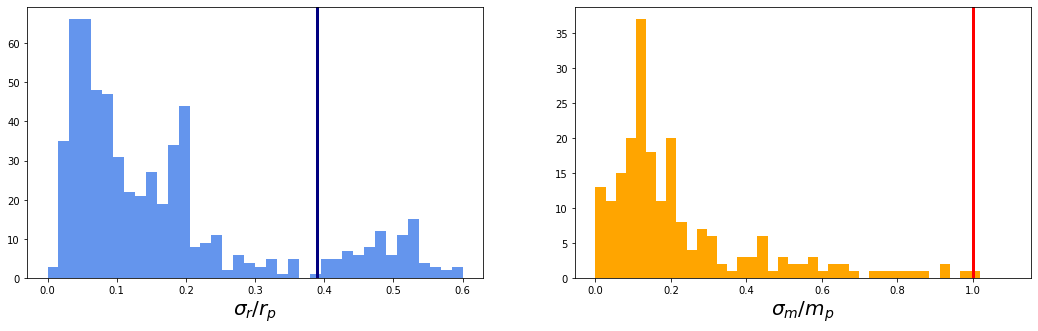

Removed planets with large uncertainties from the following systems
K2-183
K2-266
Kepler-148
Kepler-166
Kepler-171
Kepler-176
Kepler-178
Kepler-184
Kepler-191
Kepler-194
Kepler-222
Kepler-226
Kepler-228
Kepler-244
Kepler-250
Kepler-253
Kepler-254
Kepler-255
Kepler-272
Kepler-276
Kepler-288
Kepler-295
Kepler-301
Kepler-310
Kepler-325
Kepler-339
Kepler-341
Kepler-351
Kepler-357
Kepler-372
Kepler-374
Kepler-385
Kepler-399
Kepler-47
Kepler-53
Kepler-58

After removals, 633 objects in 186 systems remain


In [18]:
# check for planets with large relative mass or radius uncertainties
mass_mu = np.copy(d["mp"])
mass_std = np.sqrt(d["mp_err1"]**2 + d["mp_err2"]**2)/np.sqrt(2)

radius_mu = np.copy(d["rp"])
radius_std = np.sqrt(d["rp_err1"]**2 + d["rp_err2"]**2)/np.sqrt(2)


# here's a histogram
fig, ax = plt.subplots(1,2, figsize=(18,5))
ax[0].hist(radius_std/radius_mu, bins=np.linspace(0,0.6,39), color="cornflowerblue")
ax[0].axvline(0.39, color="navy", lw=3)
ax[0].set_xlabel(r"$\sigma_r/r_p$", fontsize=20)
ax[1].hist(mass_std/mass_mu, bins=np.linspace(0,1.1,42), color="orange")
ax[1].axvline(1.0, color="red", lw=3)
ax[1].set_xlabel(r"$\sigma_m/m_p$", fontsize=20)
plt.show()


# remove the planets with large uncertainties
bad = (radius_std/radius_mu > 0.39) + (mass_std/mass_mu > 1.0)

print("Removed planets with large uncertainties from the following systems")
for star in np.unique(d["starname"][bad]):
    print(star)
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))

# Remaining RV systems

In [19]:
RV = d['sys_disc_method'] == 'Radial Velocity'
print('Here are the remaining %d RV systems:' \
      %len(np.unique(d['starname'][RV])))
print(np.unique(d['starname'][RV]))

Here are the remaining 33 RV systems:
['47 UMa' '55 Cnc' '61 Vir' 'DMPP-1' 'GJ 1061' 'GJ 163' 'GJ 180' 'GJ 3138'
 'GJ 3293' 'GJ 581' 'GJ 676 A' 'GJ 876' 'HD 10180' 'HD 125612' 'HD 136352'
 'HD 141399' 'HD 158259' 'HD 164922' 'HD 181433' 'HD 20781' 'HD 20794'
 'HD 215152' 'HD 219134' 'HD 31527' 'HD 34445' 'HD 40307' 'HD 7924'
 'HIP 14810' 'HIP 57274' 'Wolf 1061' 'YZ Cet' 'tau Cet' 'ups And']


# Enforce detection consistency between transit and RV samples

./forecaster/mr_forecast.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  mass = truncnorm.rvs( (mlower-mean)/std, (mupper-mean)/std, loc=mean, scale=std, size=sample_size)


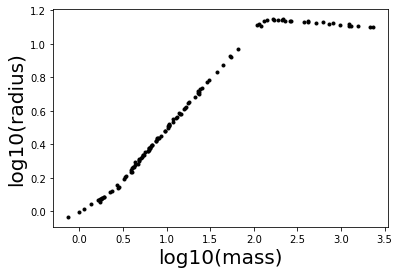

In [20]:
# determine the nominal minimum radius of any planet discovered by RVs
# use Chen & Kipping (2017) to convert mass to radius

rv_mass = d["mp"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err1 = d["mp_err1"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err2 = d["mp_err2"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err  = np.sqrt(rv_mass_err1**2 + rv_mass_err2**2)/np.sqrt(2)

bad = (rv_mass_err > 0.5*rv_mass) + np.isnan(rv_mass) + np.isnan(rv_mass_err)

rv_mass = rv_mass[~bad]
rv_mass_err = rv_mass_err[~bad]

rv_nominal_radius = np.zeros_like(rv_mass)
rv_stellar_radius = d["rs"][d["sys_disc_method"] == "Radial Velocity"][~bad]

for i, rvm in enumerate(rv_mass):
    rv_nominal_radius[i] = mr.Mstat2R(rvm, rv_mass_err[i], sample_size=1000)[0]

min_rv_radius = np.min(rv_nominal_radius[~np.isnan(rv_nominal_radius)])
    
nominal_rprs = (rv_nominal_radius*REARTH)/(rv_stellar_radius*RSUN)
min_rv_rprs = np.min(nominal_rprs[~np.isnan(nominal_rprs)])

plt.figure()
plt.plot(np.log10(rv_mass), np.log10(rv_nominal_radius), "k.")
plt.xlabel("log10(mass)", fontsize=20)
plt.ylabel("log10(radius)", fontsize=20)
plt.show()

In [21]:
# remove very small transiting planets (that wouldn't be discovered by RV)
# remove very long period RV planets (that wouldn't be discovered by Kepler)
# don't throw out the NaN values, which indicate missing data (e.g no radius for some RV planets)

d['rprs'] = (d['rp']*REARTH)/(d['rs']*RSUN)

keep = ((d["rprs"] >= min_rv_rprs) + np.isnan(d["rprs"])) * (d["p"] < 1460.)

for k in d.keys():
    d[k] = d[k][keep]

    
# recount the planets in each system and eliminate systems reduced to fewer than 3 planets
for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    

print("After removing long period and small radius objects, {0} planets in {1} systems remain"
      .format(len(d["starname"]), len(np.unique(d["starname"]))))

After removing long period and small radius objects, 518 planets in 146 systems remain


In [22]:
# recount the planets in each system
d["npl"] = np.zeros(len(d["starname"]), dtype="int")

for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    

# remove systems with fewer than 3 planets
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    
print("After removing systems with N < 3, {0} objects in {1} systems remain"
      .format(np.sum(keep), len(np.unique(d["starname"]))))

After removing systems with N < 3, 518 objects in 146 systems remain


In [23]:
# ensure that the rprs error for transit planets is > 0
for i in range(len(d['rprs'])):
    if d['sys_disc_method'][i] == 'Transit':
        if d['rprs'][i] == 0 or np.isnan(d['rprs'][i]):
            d['rprs'][i] = d['rp']*REARTH/(d['rs']*RSUN)
        if d['rprs_err1'][i] == 0 or np.isnan(d['rprs_err1'][i]):
            d['rprs_err1'][i] = d['rprs'][i]*np.sqrt((d['rp_err1'][i]/d['rp'][i])**2 + \
                                        (d['rs_err1'][i]/d['rs'][i])**2)
        if d['rprs_err2'][i] == 0 or np.isnan(d['rprs_err2'][i]):
            d['rprs_err2'][i] = d['rprs'][i]*np.sqrt((d['rp_err2'][i]/d['rp'][i])**2 + \
                                        (d['rs_err2'][i]/d['rs'][i])**2)

# Forecast masses/radii for all of the planets


In [24]:
K_mu = np.copy(d['K'])
K_std = np.sqrt(d["K_err1"]**2 + d["K_err2"]**2)/np.sqrt(2)
      
rprs_mu = np.copy(d['rprs'])
rprs_std = np.sqrt(d["rprs_err1"]**2 + d["rprs_err2"]**2)/np.sqrt(2)

Mstar_mu = np.copy(d['ms'])
Mstar_std = np.sqrt(d["ms_err1"]**2 + d["ms_err2"]**2)/np.sqrt(2)

Rstar_mu = np.copy(d['rs'])
Rstar_std = np.sqrt(d["rs_err1"]**2 + d["rs_err2"]**2)/np.sqrt(2)

NPL = len(K_mu)

K_prob = np.zeros((NPL, NBOOT))
rprs_prob = np.zeros((NPL, NBOOT))
mpms_prob = np.zeros((NPL, NBOOT))
Mstar_prob = np.zeros((NPL, NBOOT))
Rstar_prob = np.zeros((NPL, NBOOT))
mass_prob = np.zeros((NPL, NBOOT))
radius_prob = np.zeros((NPL, NBOOT))

for i in range(NPL):
    if i % 100 == 0:
        print(i)
        
    if d['sys_disc_method'][i] == 'Radial Velocity' and ~np.isnan(d['K'][i]):
        K_prob[i] = stats.truncnorm(-K_mu[i]/K_std[i], (np.inf-K_mu[i])/K_std[i], 
                                       loc=K_mu[i], scale=K_std[i]).rvs(NBOOT)
        Ms = d['ms'][i]*MSUN
        P = d['p'][i]*24*60*60
        for j in range(len(mpms_prob[i])):
            r = np.roots([2*pi*BIGG*Ms, -P*K_prob[i][j]**3, \
                                -2*P*K_prob[i][j]**3, -P*K_prob[i][j]**3])
            mpms_prob[i][j] = float(r[np.isreal(r)][0])
        Mstar_prob[i] = stats.truncnorm((0.01-Mstar_mu[i])/Mstar_std[i], (10-Mstar_mu[i])/Mstar_std[i], 
                                       loc=Mstar_mu[i], scale=Mstar_std[i]).rvs(NBOOT)
        mass_prob[i] = mpms_prob[i]*Mstar_prob[i]*MSUN/MEARTH
        radius_prob[i] = mr.Mpost2R(mass_prob[i])
        
    elif d['sys_disc_method'][i] == 'Transit' and ~np.isnan(d['rprs'][i]):
        rprs_prob[i] = stats.truncnorm((0.01-rprs_mu[i])/rprs_std[i], (0.15-rprs_mu[i])/rprs_std[i], 
                                       loc=rprs_mu[i], scale=rprs_std[i]).rvs(NBOOT)
        Rstar_prob[i] = stats.truncnorm((0.1-Rstar_mu[i])/Rstar_std[i], (5-Rstar_mu[i])/Rstar_std[i], 
                                       loc=Rstar_mu[i], scale=Rstar_std[i]).rvs(NBOOT)
        radius_prob[i] = rprs_prob[i]*Rstar_prob[i]*RSUN/REARTH
        mass_prob[i] = mr.Rpost2M(radius_prob[i])

0


<ipython-input-24-56349c1d4984>:35: ComplexWarning: Casting complex values to real discards the imaginary part
  mpms_prob[i][j] = float(r[np.isreal(r)][0])


100
200
300
400
500


In [25]:
RV = d["sys_disc_method"] == "Radial Velocity"
TTV = ~np.isnan(d["mp"]) * ~RV

# redraw bad non-RV masses
max_rv_mass = np.max(mass_prob[RV])
min_rv_mass = np.min(mass_prob[RV])
for i in range(len(rprs_prob)):
    if i % 100 == 0:
        print(i)
    for j in range(len(rprs_prob[i])):
        bad = mass_prob[i][j] > max_rv_mass or \
                mass_prob[i][j] < min_rv_mass or mass_prob[i][j]==0
        while bad==True and ~np.isnan(rprs_std[i]):
            rprs_prob[i][j] = stats.truncnorm((0.01-rprs_mu[i])/rprs_std[i], (0.15-rprs_mu[i])/rprs_std[i], 
                                       loc=rprs_mu[i], scale=rprs_std[i]).rvs(1)[0]
            Rstar_prob[i][j] = stats.truncnorm((0.1-Rstar_mu[i])/Rstar_std[i], (5-Rstar_mu[i])/Rstar_std[i], 
                                       loc=Rstar_mu[i], scale=Rstar_std[i]).rvs(1)[0]
            radius_prob[i][j] = rprs_prob[i][j]*Rstar_prob[i][j]*RSUN/REARTH
            mass_prob[i][j] = mr.Rpost2M([radius_prob[i][j]])
            bad = mass_prob[i][j] > max_rv_mass or \
                mass_prob[i][j] < min_rv_mass or mass_prob[i][j]==0

0
100
200
300
400
500


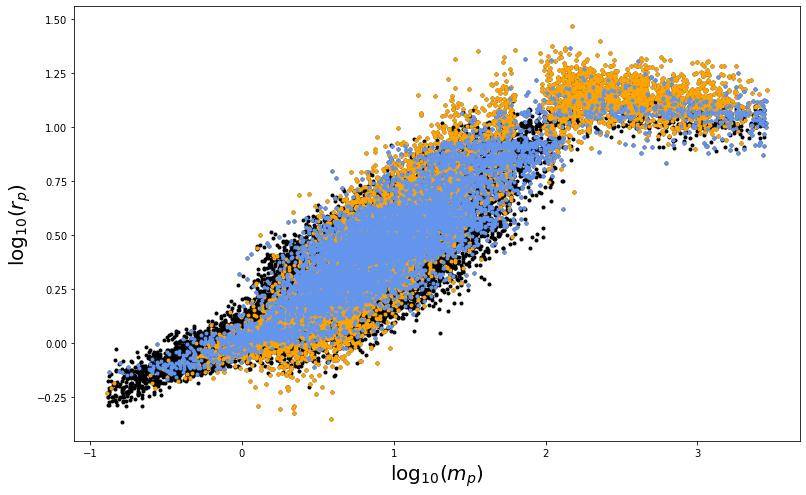

In [26]:
plt.figure(figsize=(13,8))
plt.plot(np.log10(mass_prob), np.log10(radius_prob), "k.", label='Transit')
plt.plot(np.log10(mass_prob)[RV], np.log10(radius_prob)[RV], ".", c="orange", label='RV')
plt.plot(np.log10(mass_prob)[TTV], np.log10(radius_prob)[TTV], ".", c="cornflowerblue", label='TTV')
plt.xlabel("$\log_{10}(m_p)$", fontsize=20)
plt.ylabel("$\log_{10}(r_p)$", fontsize=20)
plt.show()

# Build list of systems


In [27]:
all_systems = []
transit_systems = []
rv_systems = []
mixed_systems = []

for i, star in enumerate(np.unique(d["starname"])):
    use = d["starname"] == star
    
    s = System()
    
    # stellar/system parameters
    s.starname = d["starname"][use][0]
    s.Mstar    = d["ms"][use][0]
    s.Mstar_err = np.sqrt(d["ms_err1"][use][0]**2 + \
                          d["ms_err2"][use][0]**2)/np.sqrt(2)
    s.Rstar    = d["rs"][use][0]
    s.Rstar_err = np.sqrt(d["rs_err1"][use][0]**2 + \
                          d["rs_err2"][use][0]**2)/np.sqrt(2)
    s.det_meth = d["sys_disc_method"][use][0]
        
    
    # measured planet properties
    s.rprs = d["rprs"][use]
    s.radii = d["rp"][use]
    s.radii_err = np.sqrt(d["rp_err1"][use]**2 + \
                        d["rp_err2"][use]**2)/np.sqrt(2)
    s.masses = d['mp'][use]
    s.masses_err = np.sqrt(d["mp_err1"][use]**2 + \
                        d["mp_err2"][use]**2)/np.sqrt(2)
    s.periods = d["p"][use]
    s.N = len(s.rprs)
    
    # arrays of probabilistic mass and radius
    s.prob_mass = mass_prob[use].swapaxes(0,1)
    s.prob_radius = radius_prob[use].swapaxes(0,1)
    
    # save to lists
    all_systems.append(s)
    
    if s.det_meth == "Transit":
        transit_systems.append(s)
    elif s.det_meth == "Radial Velocity":
        rv_systems.append(s)
    elif s.det_meth == "Mixed":
        mixed_systems.append(s)
    else:
        raise ValueError("Detection method must be 'Transit',  'Radial Velocity', or 'Mixed'")

# Assign weights to stellar masses


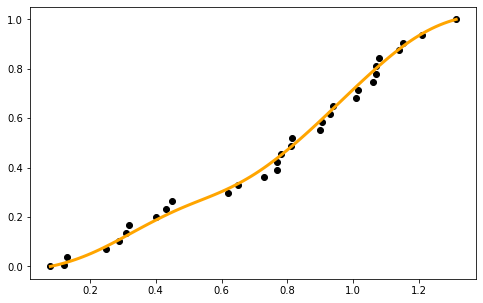

In [28]:
Mstar = []
starname = []
det_meth = []

for i, s in enumerate(all_systems):
    Mstar.append(s.Mstar)
    starname.append(s.starname)
    det_meth.append(s.det_meth)
    
Mstar = np.asarray(Mstar)
starname = np.asarray(starname)
det_meth = np.asarray(det_meth)

ms_rv = Mstar[det_meth == "Radial Velocity"]

def get_weights(arr, arr_rv, plot_on = True):
    
    # Fraction of stellar masses (any detection method) 
    # beyond RV limit
    # Visual inspection reveals only a few transit stars with 
    # masses slightly beyond RV limits
    
    low = np.sum(arr < arr_rv.min())/len(arr)
    high = np.sum(arr < arr_rv.max())/len(arr)
    
    train_x = np.sort(arr_rv + np.random.normal(loc=0, \
                scale=100*sys.float_info.epsilon, size=len(arr_rv)))
    train_x = np.hstack([arr.min(), train_x, arr.max()])
    
    train_y = np.linspace(low, high, len(arr_rv))
    train_y = np.hstack([0, train_y, 1])
    
    spline = scipy.interpolate.PchipInterpolator(train_x, train_y)
    
    fit_x = np.linspace(train_x.min(), train_x.max(), 100)
    fit_y = spline(fit_x)
    
    win = sig.hann(49)
    win /= np.sum(win)
    
    fit_y_padded = np.pad(fit_y, (50,50), "edge")
    fit_y_smooth = sig.convolve(fit_y_padded, win, "same")[50:-50]
    
    fit_y_smooth = (fit_y_smooth-min(fit_y_smooth))/(max(fit_y_smooth)\
                                                     -min(fit_y_smooth))
    
    spline = scipy.interpolate.PchipInterpolator(fit_x, fit_y_smooth)

    if plot_on:
        plt.figure(figsize=(8,5))
        plt.plot(train_x, train_y, "ko")
        plt.plot(fit_x, spline(fit_x), c="orange", lw=3)
        plt.show()
    
    return arr[det_meth == "Transit"], spline(arr[det_meth == "Transit"])

ms_tr, w_tr = get_weights(Mstar, ms_rv)

# Now we can draw samples and compare cdfs


In [29]:
# dictionaries to hold p-values for Kolmogorov-Smirnov and Anderson-Darling tests
KS = {}
AD = {}

In [30]:
def perturbed_ks_2samp(x1, x2):
    n, m = len(x1), len(x2)
    
    D, p = stats.ks_2samp(x1, x2)

    eps_low  = np.min([D, 0.5/np.sqrt(n*m)])
    eps_high = np.min([1-D, 0.5/np.sqrt(n*m)])
    
    D_new = D + np.random.uniform(-eps_low, eps_high)
    p_new = 2*np.exp(-(2*m*D_new**2)/(1+m/n))
    
    return D_new, p_new


def extrapolated_anderson_2samp(x1, x2):
    A, cv, p = stats.anderson_ksamp([x1, x2])

    alpha = np.array([0.25, 0.10, 0.05, 0.025, 0.01, 0.005, 0.001])
    
    res_fxn = lambda theta, x, y: y - 1/(1 + theta[0]*np.exp(x/theta[1]))
    
    fit, success = op.leastsq(res_fxn, [0.25, 1], args=(cv, alpha))
    
    z = np.linspace(-2,6)
    p_new = 1/(1 + fit[0]*np.exp(A/fit[1]))
    
    return A, p_new

# Here's the plotting function

In [31]:
def quick_plot(data, ks, ad, datalabel, gridsize=1000, colors=["k", "r"], labels=["Transit", "RV"]):    
    
    if colors is None:
        colors = []
        for k in range(len(data)):
            colors.append("C{0}".format(k))
    
    fig, ax = plt.subplots(1,2, figsize=(16,5))        
    
    for k, x in enumerate(data):

        X = np.linspace(x.min(), x.max(), gridsize)
        Y = np.zeros((x.shape[0], gridsize))

        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                Y[i,j] = np.sum(x[i] <= X[j])

        Y /= x.shape[1]

        Y_mean = Y.mean(0)
        Y_up = Y_mean + Y.std(0)
        Y_dn = Y_mean - Y.std(0)

        Y_up[Y_up > 1.0] = 1.0
        Y_dn[Y_dn < 0.0] = 0.0
        
        
        # enforce monotonicity of bounds
        for i in range(1,gridsize):
            if Y_up[i] < Y_up[i-1]:
                Y_up[i] = Y_up[i-1]
        
        for i in range(1,gridsize):
            if Y_dn[gridsize-i-1] > Y_dn[gridsize-i]:
                Y_dn[gridsize-i-1] = Y_dn[gridsize-i]

        ax[0].plot(X, Y_mean, c=colors[k], label=labels[k])
        ax[0].plot(X, Y_up, c=colors[k], ls=":")
        ax[0].plot(X, Y_dn, c=colors[k], ls=":")
        ax[0].fill_between(X, Y_up, Y_dn, color=colors[k], alpha=0.1)
        ax[0].legend(fontsize=16)
        ax[0].set_xlabel(datalabel, fontsize=20)
        ax[0].set_ylabel("cdf", fontsize=20)
        
    ax[1].hist(np.log10(ks), color="cornflowerblue", histtype="step", lw=3, label="KS")
    ax[1].hist(np.log10(ad), color="orange", histtype="step", lw=3, label="AD")
    ax[1].axvline(np.log10(np.mean(ks)), color="navy", lw=3, ls="--")
    ax[1].axvline(np.log10(np.mean(ad)), color="red", lw=3, ls="--")
    ax[1].set_xlabel("p-value", fontsize=20)
    ax[1].set_yticks([])
    ax[1].legend(loc="upper left", fontsize=16)


    return fig, ax

# Dynamical mass, $\mu$


<ipython-input-30-6533cbc65217>:16: UserWarning: p-value floored: true value smaller than 0.001
  A, cv, p = stats.anderson_ksamp([x1, x2])


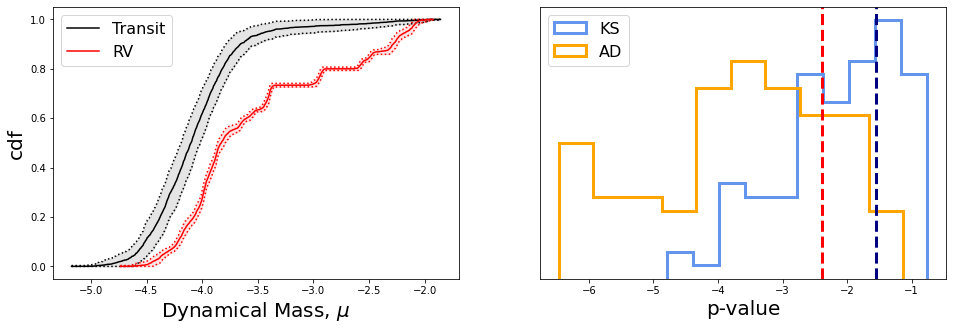

In [32]:
Nsys = len(ms_rv)

KS["mu"] = np.zeros(NBOOT)
AD["mu"] = np.zeros(NBOOT)

mu_rv = np.zeros((NBOOT,Nsys))
mu_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        mu_rv[i,j] = archinfo.mu(rv_systems[j].prob_mass[i], rv_systems[j].Mstar)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        mu_tr[i,j] = archinfo.mu(transit_systems[loc].prob_mass[i], transit_systems[loc].Mstar)
        
    mu_rv[i] = np.sort(mu_rv[i])
    mu_tr[i] = np.sort(mu_tr[i])
    
    # p-values
    KS["mu"][i] = perturbed_ks_2samp(mu_rv[i], mu_tr[i])[1]
    AD["mu"][i] = extrapolated_anderson_2samp(mu_rv[i], mu_tr[i])[1]

logmu_rv = np.log10(mu_rv)
logmu_tr = np.log10(mu_tr)


fig, ax = quick_plot([logmu_tr, logmu_rv], KS["mu"], AD["mu"], "Dynamical Mass, $\mu$")

# Normalized dynamical mass, $\mu/N$


<ipython-input-30-6533cbc65217>:16: UserWarning: p-value floored: true value smaller than 0.001
  A, cv, p = stats.anderson_ksamp([x1, x2])


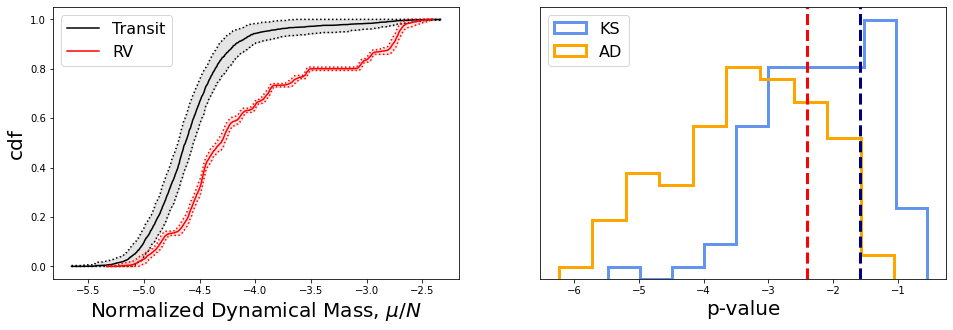

In [33]:
Nsys = len(ms_rv)

KS["mu_N"] = np.zeros(NBOOT)
AD["mu_N"] = np.zeros(NBOOT)

mu_N_rv = np.zeros((NBOOT,Nsys))
mu_N_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        mu_N_rv[i,j] = archinfo.mu(rv_systems[j].prob_mass[i], rv_systems[j].Mstar)/rv_systems[j].N
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        mu_N_tr[i,j] = archinfo.mu(transit_systems[loc].prob_mass[i], \
                                   transit_systems[loc].Mstar)/transit_systems[loc].N

    mu_N_rv[i] = np.sort(mu_N_rv[i])
    mu_N_tr[i] = np.sort(mu_N_tr[i])
    
    # p-values 
    KS["mu_N"][i] = perturbed_ks_2samp(mu_N_rv[i], mu_N_tr[i])[1]
    AD["mu_N"][i] = extrapolated_anderson_2samp(mu_N_rv[i], mu_N_tr[i])[1]


logmu_N_rv = np.log10(mu_N_rv)
logmu_N_tr = np.log10(mu_N_tr)


fig, ax = quick_plot([logmu_N_tr, logmu_N_rv], KS["mu_N"], AD["mu_N"], \
                     "Normalized Dynamical Mass, $\mu/N$")

# Mass partitioning, Q


<ipython-input-30-6533cbc65217>:16: UserWarning: p-value capped: true value larger than 0.25
  A, cv, p = stats.anderson_ksamp([x1, x2])


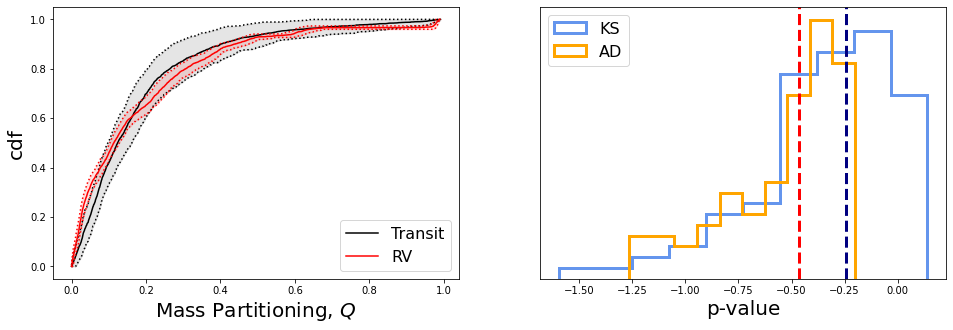

In [34]:
Nsys = len(ms_rv)

KS["Q"] = np.zeros(NBOOT)
AD["Q"] = np.zeros(NBOOT)

Q_rv = np.zeros((NBOOT,Nsys))
Q_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        Q_rv[i,j] = archinfo.Q(rv_systems[j].prob_mass[i])
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        
        Q_tr[i,j] = archinfo.Q(transit_systems[loc].prob_mass[i])


    Q_rv[i] = np.sort(Q_rv[i])
    Q_tr[i] = np.sort(Q_tr[i])
    
    # p-values
    KS["Q"][i] = perturbed_ks_2samp(Q_rv[i], Q_tr[i])[1]
    AD["Q"][i] = extrapolated_anderson_2samp(Q_rv[i], Q_tr[i])[1]
        
        
fig, ax = quick_plot([Q_tr, Q_rv], KS["Q"], AD["Q"], "Mass Partitioning, $Q$")

# Monotonicity, M


<ipython-input-30-6533cbc65217>:16: UserWarning: p-value capped: true value larger than 0.25
  A, cv, p = stats.anderson_ksamp([x1, x2])
<ipython-input-30-6533cbc65217>:16: UserWarning: p-value floored: true value smaller than 0.001
  A, cv, p = stats.anderson_ksamp([x1, x2])


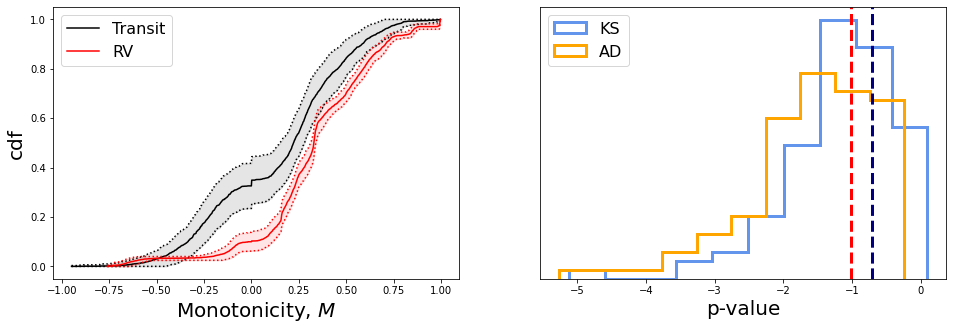

In [35]:
Nsys = len(ms_rv)

KS["M"] = np.zeros(NBOOT)
AD["M"] = np.zeros(NBOOT)

M_rv = np.zeros((NBOOT,Nsys))
M_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        M_rv[i,j] = archinfo.M(rv_systems[j].periods, rv_systems[j].prob_mass[i])
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        M_tr[i,j] = archinfo.M(transit_systems[loc].periods, transit_systems[loc].prob_mass[i])


    M_rv[i] = np.sort(M_rv[i])
    M_tr[i] = np.sort(M_tr[i])
    
    # p-values
    KS["M"][i] = perturbed_ks_2samp(M_rv[i], M_tr[i])[1]
    AD["M"][i] = extrapolated_anderson_2samp(M_rv[i], M_tr[i])[1]
        
        
fig, ax = quick_plot([M_tr, M_rv], KS["M"], AD["M"], "Monotonicity, $M$")

# Gap complexity, C


<ipython-input-30-6533cbc65217>:16: UserWarning: p-value floored: true value smaller than 0.001
  A, cv, p = stats.anderson_ksamp([x1, x2])
<ipython-input-30-6533cbc65217>:16: UserWarning: p-value capped: true value larger than 0.25
  A, cv, p = stats.anderson_ksamp([x1, x2])


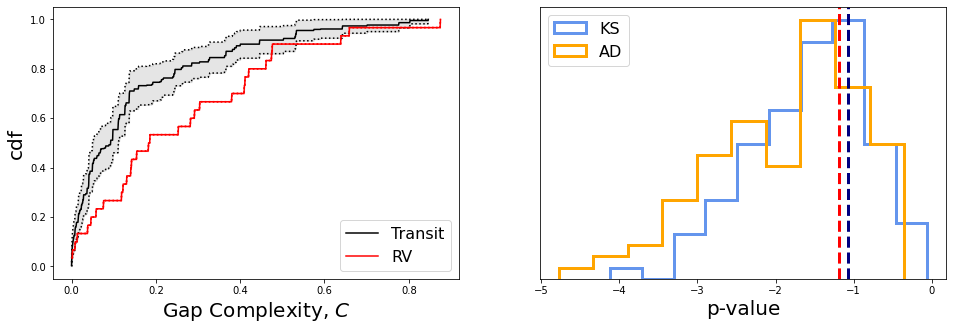

In [36]:
Nsys = len(ms_rv)

KS["C"] = np.zeros(NBOOT)
AD["C"] = np.zeros(NBOOT)

C_rv = np.zeros((NBOOT,Nsys))
C_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        C_rv[i,j] = archinfo.C(rv_systems[j].periods)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        C_tr[i,j] = archinfo.C(transit_systems[loc].periods)


    C_rv[i] = np.sort(C_rv[i])
    C_tr[i] = np.sort(C_tr[i])
    
    # p-values
    KS["C"][i] = perturbed_ks_2samp(C_rv[i], C_tr[i])[1]
    AD["C"][i] = extrapolated_anderson_2samp(C_rv[i], C_tr[i])[1]
        
        
fig, ax = quick_plot([C_tr, C_rv], KS["C"], AD["C"], "Gap Complexity, $C$")

# Characteristic Spacing, S


<ipython-input-30-6533cbc65217>:16: UserWarning: p-value capped: true value larger than 0.25
  A, cv, p = stats.anderson_ksamp([x1, x2])


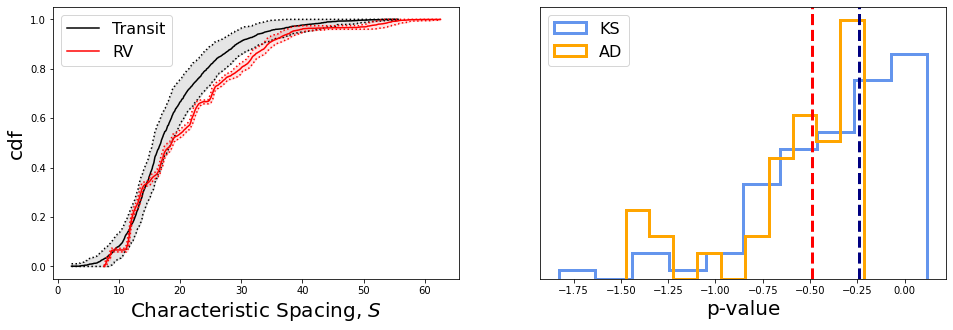

In [37]:
Nsys = len(ms_rv)

KS["S"] = np.zeros(NBOOT)
AD["S"] = np.zeros(NBOOT)

S_rv = np.zeros((NBOOT,Nsys))
S_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        S_rv[i,j] = archinfo.S(rv_systems[j].periods, rv_systems[j].prob_mass[i], rv_systems[j].Mstar)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        S_tr[i,j] = archinfo.S(transit_systems[loc].periods, transit_systems[loc].prob_mass[i], 
                               transit_systems[loc].Mstar)


    S_rv[i] = np.sort(S_rv[i])
    S_tr[i] = np.sort(S_tr[i])
    
    # p-values
    KS["S"][i] = perturbed_ks_2samp(S_rv[i], S_tr[i])[1]
    AD["S"][i] = extrapolated_anderson_2samp(S_rv[i], S_tr[i])[1]
        
        
fig, ax = quick_plot([S_tr, S_rv], KS["S"], AD["S"], "Characteristic Spacing, $S$")